In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime
import geopandas as gpd 

%load_ext autoreload
%autoreload 2

### 1. Data import

#### 1.2 Read US shapefiles

<Axes: >

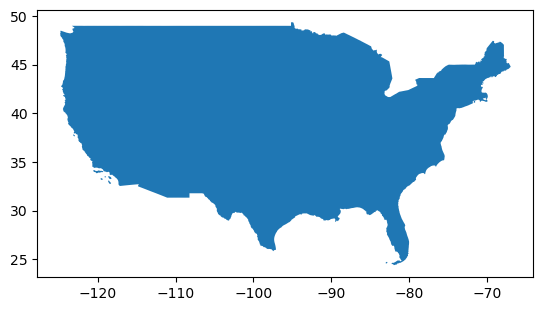

In [2]:
us_shape = gpd.read_file('../data/tl_2018_us_county/tl_2018_us_county.shp').to_crs("EPSG:4326")

# filter continental US
us_continental_counties = us_shape.cx[-66:-125, 24:50].reset_index(drop=True)
us_continental_boundary = us_continental_counties.dissolve()
us_continental_boundary.plot()

#### 1.2 Read MODIS start dates

In [110]:
modis_dates = pd.read_csv("../data/MODIS_dates.csv", sep=";").dropna()
modis_dates = modis_dates.apply(lambda x: pd.to_datetime(x, format="%Y%m%d"))

modis_dates.iloc[6:9]

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
6,2003-02-18,2004-02-18,2005-02-18,2006-02-18,2007-02-18,2008-02-18,2009-02-18,2010-02-18,2011-02-18,2012-02-18,2013-02-18,2014-02-18,2015-02-18,2016-02-18,2017-02-18,2018-02-18,2019-02-18,2020-02-18,2021-02-18
7,2003-02-26,2004-02-26,2005-02-26,2006-02-26,2007-02-26,2008-02-26,2009-02-26,2010-02-26,2011-02-26,2012-02-26,2013-02-26,2014-02-26,2015-02-26,2016-02-26,2017-02-26,2018-02-26,2019-02-26,2020-02-26,2021-02-26
8,2003-03-06,2004-03-05,2005-03-06,2006-03-06,2007-03-06,2008-03-05,2009-03-06,2010-03-06,2011-03-06,2012-03-05,2013-03-06,2014-03-06,2015-03-06,2016-03-05,2017-03-06,2018-03-06,2019-03-06,2020-03-05,2021-03-06


#### 1.3 Read ECMWF seasonal forecasts

In [198]:
month = "sep"

In [199]:
filtered_coords = pd.read_csv("../data/filtered_coords_ecmwf.csv")
# read hindcasts
list_hindcasts = []
#for filename in ["apr_2003_09", "apr_2010_16", "apr_2017_23"]:
for filename in ["{}_2003_09".format(month), "{}_2010_16".format(month), "{}_2017_23".format(month)]:
    print("reading {}".format(filename))
    df = xr.open_dataset("../data/ecmwf_grib/" + filename.lower() + ".grib")
    print("ensembles mean") # Note: This is subject to change for probabilistic forecasting
    df = df.mean("number")
    print("to dataframe")
    df = df.to_dataframe().dropna().reset_index()
    print("filter coordinates to continental US")
    df = df.merge(filtered_coords[["latitude", "longitude"]], on=["latitude", "longitude"], how="right")
    print("convert to datetime")
    df["valid_time"] = pd.to_datetime(df["valid_time"])
    df["time"] = pd.to_datetime(df["time"])
    list_hindcasts.append(df)

ecmwf = pd.concat(list_hindcasts, ignore_index=True)

reading sep_2003_09
ensembles mean
to dataframe
filter coordinates to continental US
convert to datetime
reading sep_2010_16
ensembles mean
to dataframe
filter coordinates to continental US
convert to datetime
reading sep_2017_23
ensembles mean
to dataframe
filter coordinates to continental US
convert to datetime


In [200]:
ecmwf.to_csv("../data/ecmwf_csv/ecmwf_{}.csv".format(month), index=False)

In [131]:
#ecmwf_apr = pd.read_csv("../data/ecmwf_csv/ecmwf_apr.csv")

#ecmwf_apr["valid_time"] = pd.to_datetime(ecmwf_apr["valid_time"])
#ecmwf_apr["time"] = pd.to_datetime(ecmwf_apr["time"])

### 2. Preprocess

#### 2.1 Align with date bins from MODIS

In [202]:
li = []
for year in list(range(2003, 2022)):
    # Filter by year. MODIS bins for each year are 8-day periods but the last bin may not be complete and stops at the end of the year
    ecmwf_year = ecmwf[(ecmwf["time"].dt.year == year) & (ecmwf["valid_time"].dt.year == year)].reset_index(drop=True)
    # For faster resampling, we will use the location as a string
    ecmwf_year["location"] = ecmwf_year["latitude"].astype(int).astype(str) + ", " + ecmwf_year["longitude"].astype(int).astype(str)
    # start date of first bin is the first purely forecasted bin
    start_date = pd.to_datetime(np.intersect1d(modis_dates[str(year)].values, ecmwf_year["valid_time"].drop_duplicates().sort_values()).min())
    # start date of last bin is the max
    end_date = modis_dates[str(year)].max()
    
    # NOTE: For wheat data we may need to use the following line because the season ends in August and the last bin will be complete        
    #end_date = min(pd.to_datetime(datetime(year, 12, 31)), pd.to_datetime(np.intersect1d(modis_dates[str(year)].values, ecmwf_year["valid_time"].drop_duplicates().sort_values()[:-7]).max()))
    
    days_to_end_of_forecast = (end_date - start_date).days + 1
    dates_to_end_of_forecast = pd.date_range(start_date, periods=days_to_end_of_forecast, freq='D')
    
    ecmwf_year_resampled = (
                            pd.DataFrame(dates_to_end_of_forecast, index=range(days_to_end_of_forecast), columns=["start_date_bin"])
                                .merge(ecmwf_year, left_on="start_date_bin", right_on="valid_time", how="left")
                                .groupby(["time", "location"]).resample("8D", on="start_date_bin")[["t2m", "mx2t24", "mn2t24", "tp"]].mean()
                                .reset_index()
                            )

    li.append(ecmwf_year_resampled)

ecmwf_resampled = pd.concat(li, ignore_index=True)

In [203]:
ecmwf_resampled.head()

,time,location,start_date_bin,t2m,mx2t24,mn2t24,tp
0,2003-09-01,"25, -81",2003-09-06,300.755341,302.400391,299.286682,0.040281
1,2003-09-01,"25, -81",2003-09-14,300.477753,302.050354,298.984253,0.078810
2,2003-09-01,"25, -81",2003-09-22,300.297791,301.902893,298.771484,0.116847
3,2003-09-01,"25, -81",2003-09-30,300.033234,301.613586,298.649719,0.158320
4,2003-09-01,"25, -81",2003-10-08,299.815338,301.374939,298.496033,0.206057


#### 2.2 Assign counties to grid cells

Create final dataframe with countyID, init_date and modis_bin as indices.


We will later use this dataframe to merge the ECMWF forecasts on.

In [204]:
counties_with_ecmwf = pd.DataFrame(index=pd.MultiIndex.from_product([ecmwf_resampled["time"].unique(), ecmwf_resampled["start_date_bin"].unique(), us_continental_counties.GEOID.unique()], 
                                                                    names=["init_date", "modis_bin", "GEOID"])).reset_index()

counties_with_ecmwf = counties_with_ecmwf.loc[(counties_with_ecmwf["init_date"].dt.year == counties_with_ecmwf["modis_bin"].dt.year)].reset_index(drop=True)

counties_with_ecmwf = counties_with_ecmwf.merge(us_continental_counties[["GEOID", "geometry"]], left_on="GEOID", right_on="GEOID", how="left").set_index(["init_date", "modis_bin", "GEOID"])
counties_with_ecmwf = gpd.GeoDataFrame(counties_with_ecmwf[["geometry"]], geometry="geometry").reset_index()

print(counties_with_ecmwf.shape)
counties_with_ecmwf.head()

(885780, 4)


,init_date,modis_bin,GEOID,geometry
0,2003-09-01,2003-09-06,31039,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,2003-09-01,2003-09-06,53069,"POLYGON ((-123.43640 46.23819, -123.44759 46.2..."
2,2003-09-01,2003-09-06,35011,"POLYGON ((-104.56739 33.99756, -104.56772 33.9..."
3,2003-09-01,2003-09-06,31109,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,2003-09-01,2003-09-06,31129,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


Spatial join unique county geometries with unique ECMWF grid cells.

https://gis.stackexchange.com/questions/466703/warning-message-when-doing-spatial-join-nearest-neighbor-on-geopandas

In [205]:
# reproject county polygons from geographic to planar coordinates
counties_geo_df = us_continental_counties[["GEOID", "geometry"]].to_crs(epsg=32723)

# extract latitude and longitude from location column in ECWMF dataframe
ecmwf_unique_lat_lon = ecmwf_resampled["location"].str.split(", ", expand=True).rename(columns={0: "latitude", 1: "longitude"}).drop_duplicates().reset_index(drop=True)

# convert ECMWF lat-lon pairs to geodataframe
ecmwf_unique_lat_lon_geo_df = gpd.GeoDataFrame(ecmwf_unique_lat_lon, geometry=gpd.points_from_xy(ecmwf_unique_lat_lon["longitude"], ecmwf_unique_lat_lon["latitude"]), crs="EPSG:4326").to_crs(epsg=32723)

# spatial join of county polygons to ECMWF lat-lon pairs
county_shapes_to_ecmwf_grids = gpd.sjoin_nearest(counties_geo_df, ecmwf_unique_lat_lon_geo_df, how="left")

# preview
county_shapes_to_ecmwf_grids.head()

,GEOID,geometry,index_right,latitude,longitude
0,31039,"POLYGON ((-3785295.209 16172646.240, -3785220....",562,42,-97
1,53069,"POLYGON ((-4764669.407 18788181.321, -4763298....",737,46,-123
2,35011,"POLYGON ((-5224522.447 15893336.533, -5224553....",136,34,-104
3,31109,"POLYGON ((-3885136.861 16037322.619, -3884654....",509,41,-97
4,31129,"POLYGON ((-4058515.761 16057472.186, -4058514....",457,40,-98


Note: Some counties have several ECMWF grid cells assigned because they are large. Other counties share the same grid cell because they are small and no grid cell intersects with them.

<Axes: >

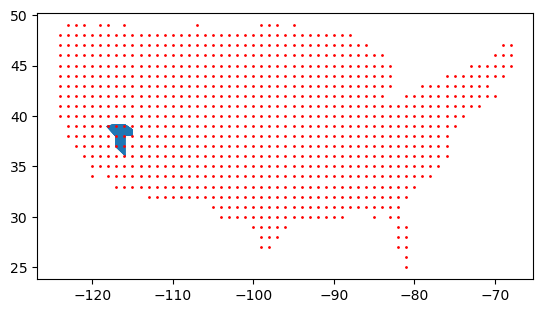

In [206]:
ax = county_shapes_to_ecmwf_grids.loc[county_shapes_to_ecmwf_grids["GEOID"] == "32023"].to_crs(4326).plot()
ecmwf_unique_lat_lon_geo_df.to_crs(4326).plot(ax=ax, color="red", markersize=1)

Bring it all together

In [207]:
counties_with_ecmwf = counties_with_ecmwf.merge(county_shapes_to_ecmwf_grids.drop(["index_right", "geometry"], axis=1), on="GEOID", how="left")

counties_with_ecmwf["location"] = counties_with_ecmwf["latitude"].astype(str) + ", " + counties_with_ecmwf["longitude"].astype(str)

counties_with_ecmwf = counties_with_ecmwf.merge(ecmwf_resampled.rename({"time":"init_date", "start_date_bin":"modis_bin"}, axis=1), on=["init_date", "modis_bin", "location"], how="left")

counties_with_ecmwf = counties_with_ecmwf.groupby(["init_date", "modis_bin", "GEOID"])[["t2m", "mx2t24", "mn2t24", "tp"]].mean().reset_index()

counties_with_ecmwf.head()

,init_date,modis_bin,GEOID,t2m,mx2t24,mn2t24,tp
0,2003-09-01,2003-09-06,01001,297.343201,301.139008,292.961792,0.027565
1,2003-09-01,2003-09-06,01003,298.640076,301.865692,295.134003,0.038282
2,2003-09-01,2003-09-06,01005,297.246124,300.922974,293.630432,0.033429
3,2003-09-01,2003-09-06,01007,297.343201,301.139008,292.961792,0.027565
4,2003-09-01,2003-09-06,01009,296.637482,300.350403,292.093567,0.030895


In [208]:
counties_with_ecmwf.modis_bin.max()

Timestamp('2021-12-27 00:00:00')

In [209]:
counties_with_ecmwf.loc[(counties_with_ecmwf["modis_bin"].dt.month == 12) & (counties_with_ecmwf["modis_bin"].dt.day == 26)]

,init_date,modis_bin,GEOID,t2m,mx2t24,mn2t24,tp
90132,2004-09-01,2004-12-26,01001,279.875336,284.496735,275.706573,0.371011
90133,2004-09-01,2004-12-26,01003,283.639862,287.351257,279.420166,0.402317
90134,2004-09-01,2004-12-26,01005,281.407562,285.925598,277.394226,0.378829
90135,2004-09-01,2004-12-26,01007,279.875336,284.496735,275.706573,0.371011
90136,2004-09-01,2004-12-26,01009,278.232483,282.906342,274.148804,0.381969
...,...,...,...,...,...,...,...
839155,2020-09-01,2020-12-26,56037,263.993011,267.598938,258.156738,0.102563
839156,2020-09-01,2020-12-26,56039,262.932648,266.535187,257.109802,0.209571
839157,2020-09-01,2020-12-26,56041,266.213165,269.389893,259.745209,0.143072
839158,2020-09-01,2020-12-26,56043,265.569611,270.450256,259.291779,0.113728


In [210]:
counties_with_ecmwf.to_csv("../data/ecmwf_features/counties_with_ecmwf_{}.csv".format(month), index=False)

### 3. Read Numpy feature arrays

**This notebook**
 - filter GEOID using unique names from numpy vectors "filename.str.split("_")[1]"
 - remove tmean column
 - convert units to match channels 7 (tmin), 8 (tmax), 9 (prcp)

**New Notebook**

 - 3_bias_adjustment_and_feature_vector
 - create raw np arrays without bias adjustment (talk to stella about validation procedure and bias adjustment approach)
 - for publication: subsequently marking channels row-wise (time-steps) with NaNs starting from the back vs. filling channels 7-9 with ECMWF data
 - channel 10 and 11 ignored (talk to Stella)


In [211]:
pd.DataFrame(np.load("../data/npy_corn_2003_2021/corn/2003_18081.npy"))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,4471.041016,4939.498047,4208.322754,4425.517578,3338.426270,1345.852661,672.548523,-0.750949,2.995658,6.535676,0.000000,0.0,0.078574,0.125561,0.167490
1,1019.638977,1990.063477,513.619385,836.048523,2582.642822,2620.005615,1876.190308,-5.417361,2.445076,0.209505,0.000000,0.0,0.321128,0.548227,-0.131189
2,7200.260254,7275.362793,6933.119629,7114.281738,4550.923340,1551.223877,789.437500,-13.239975,-2.744755,0.762845,0.000000,0.0,0.005887,0.008787,0.228712
3,6752.841309,6808.677246,6542.752930,6728.282715,4813.287109,2947.435547,1994.531738,-16.647928,-4.786656,0.573849,0.100000,0.0,0.005241,0.007843,0.173946
4,974.949646,1875.863770,500.453369,792.661377,2426.889893,2259.382568,1443.019531,-4.323888,3.433879,1.552464,0.000000,0.0,0.313604,0.532567,-0.129597
5,7154.977539,7291.972168,6794.303223,7052.527832,4537.630371,1442.235962,652.868469,-10.668303,0.011041,1.780565,0.000000,0.0,0.011410,0.017025,0.233079
6,-28672.000000,-28672.000000,-28672.000000,-28672.000000,-28672.000000,-28672.000000,-28672.000000,-6.719822,0.545951,5.310023,0.000000,0.0,0.000000,0.000000,0.000000
7,7724.415039,7564.901855,7555.877930,7724.332031,5760.311523,4659.193848,3489.237793,-7.931500,-0.702243,3.732683,0.000000,0.0,-0.010378,-0.015179,0.139411
8,1402.398315,2506.826416,736.901123,1159.213623,3076.212646,2861.715576,1791.099854,-5.787465,5.602445,0.846044,0.000000,0.0,0.285443,0.477076,-0.103401
9,1057.657593,2050.525146,546.416016,857.257446,2653.083008,2605.169678,1669.707031,-2.321684,13.601690,1.672161,0.000000,0.0,0.315671,0.536091,-0.129566
